In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
df = pd.read_csv('../data/PopByAgeGroupSupplemented.csv')
df.drop(columns=['STATISTIC', 'UNIT'], inplace=True)

df = df[['Year', 'Under 1 year', '1 - 4 years', '5 - 9 years', '10 - 14 years', 
             '15 - 19 years', '20 - 24 years', '25 - 29 years', '30 - 34 years', 
             '35 - 39 years', '40 - 44 years', '45 - 49 years', '50 - 54 years', 
             '55 - 59 years', '60 - 64 years', '65 - 69 years', '70 - 74 years', 
             '75 - 79 years', '80 - 84 years', '85 years and over']]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['Year']))

train_split_size = int(len(df_scaled) * 0.8)
train_df, test_df = df_scaled[:train_split_size + 1], df_scaled[train_split_size:]

In [3]:
def create_df(df, lag):
    X, y = [], []
    for i in range(len(df) - lag):
        X.append(df[i:(i + lag), :])
        y.append(df[i + lag, :])
    return np.array(X), np.array(y)

X_train, y_train = create_df(train_df, 5)
X_test, y_test = create_df(test_df, 5)

# X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [5]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=30, return_sequences=False))
model.add(Dense(units=19))

model.compile(optimizer='lion', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

C:\Users\bayan\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
pred = model.predict(X_test)

pred_actual = scaler.inverse_transform(pred)
y_test_actual = scaler.inverse_transform(y_test)

rmse = root_mean_squared_error(y_test_actual, pred_actual)
print(f"RMSE (in thousands of people): {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
RMSE (in thousands of people): 52.843941642387385


In [7]:
print(pred_actual.shape)  # Should be (num_samples, 19)
print(y_test_actual.shape)  # Should be (num_samples, 19)

(10, 19)
(10, 19)


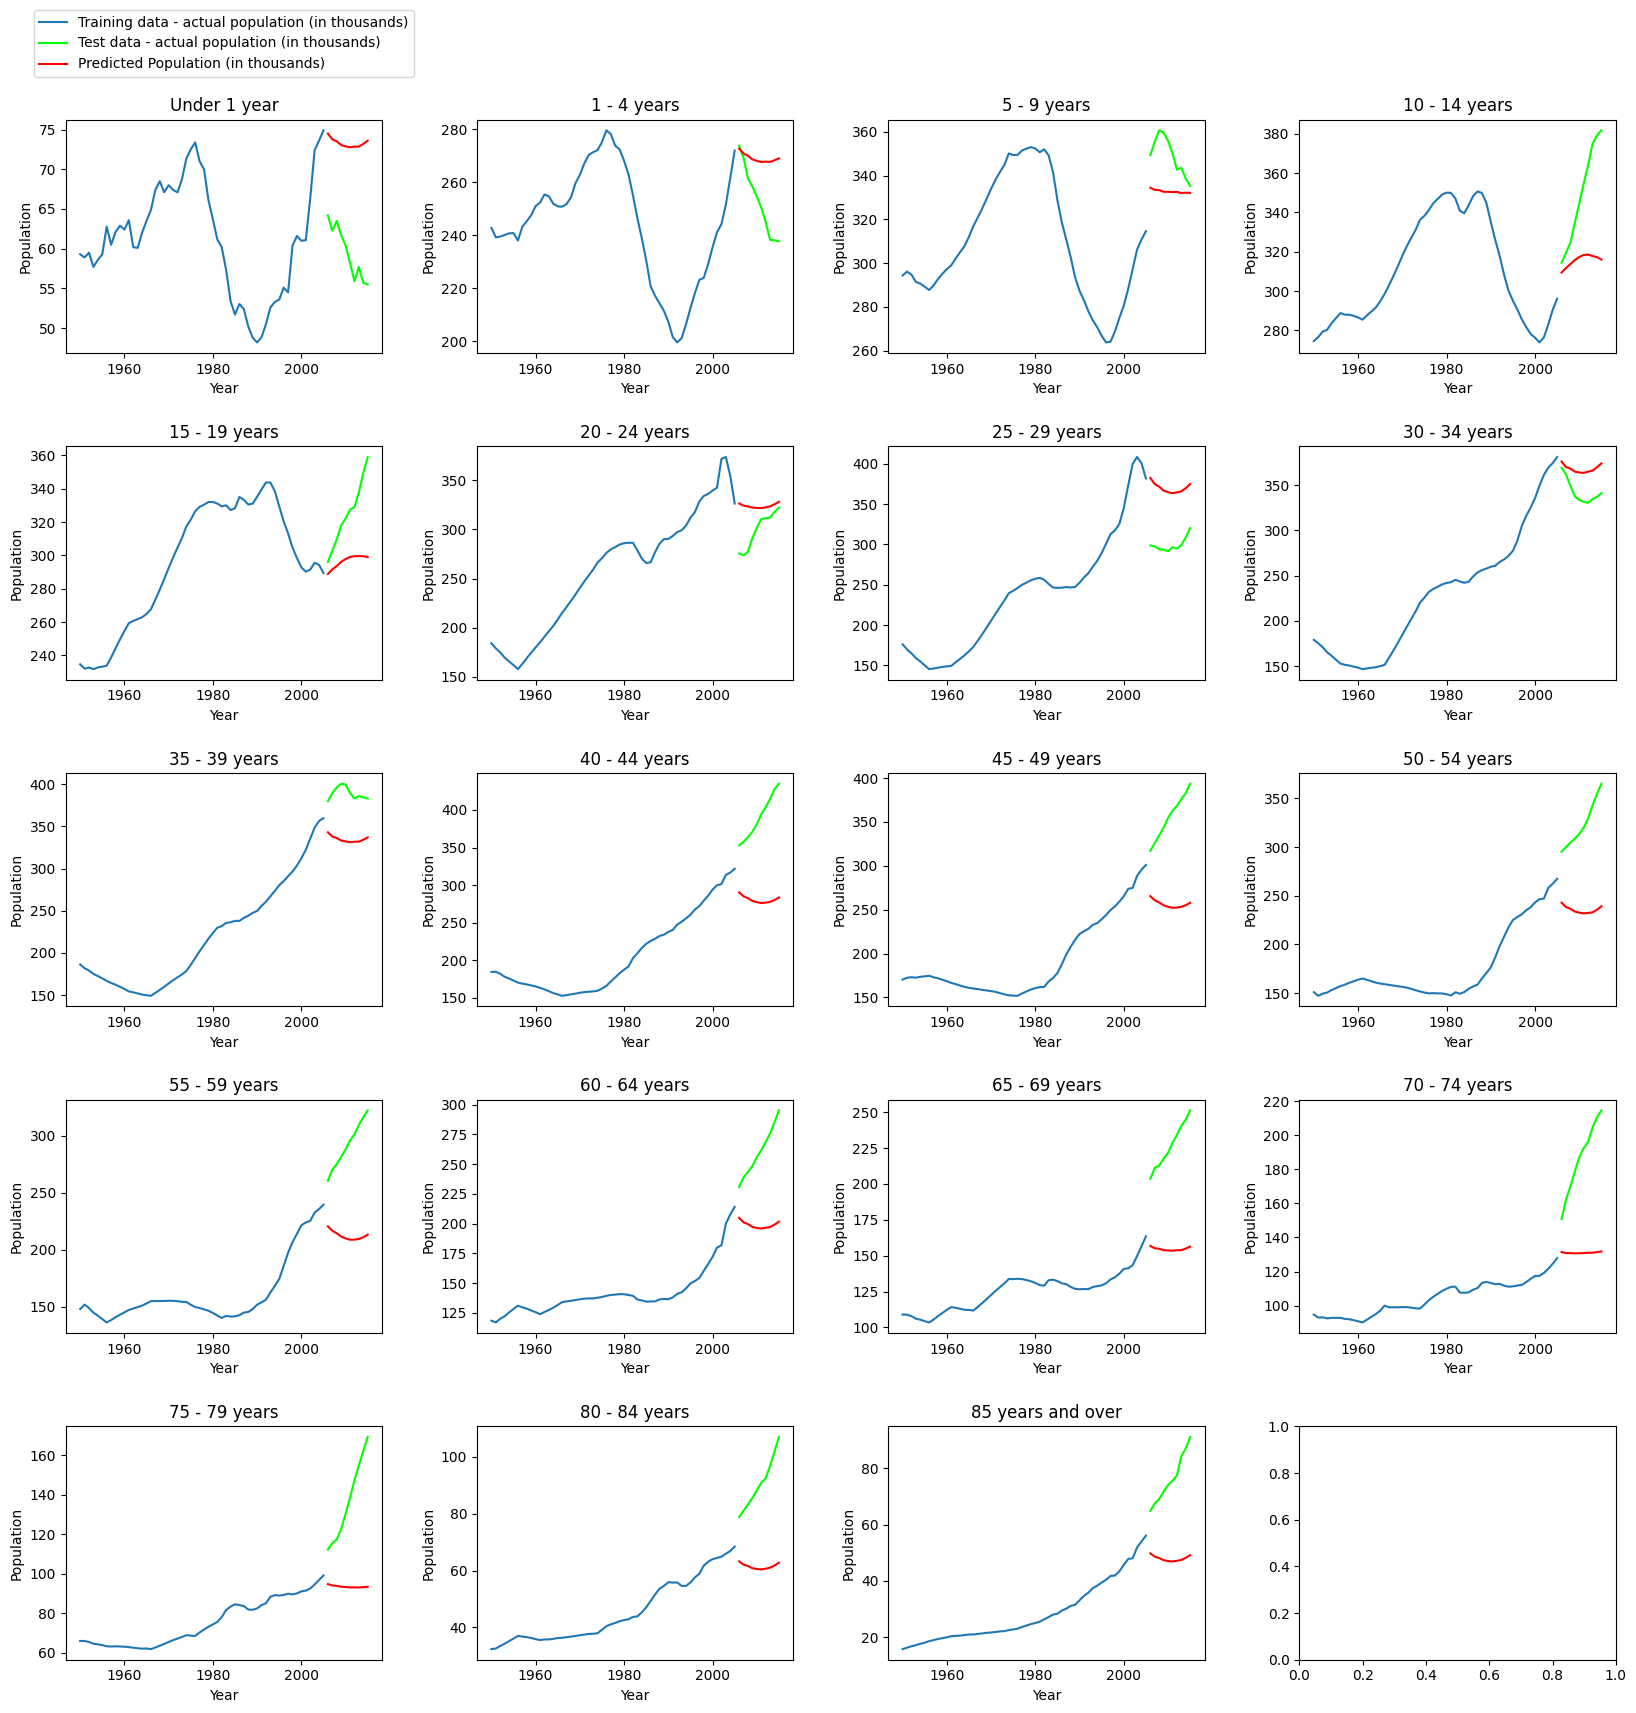

In [8]:
age_groups = np.array(['Under 1 year', '1 - 4 years', '5 - 9 years', '10 - 14 years', '15 - 19 years', '20 - 24 years', '25 - 29 years', '30 - 34 years', '35 - 39 years', '40 - 44 years', '45 - 49 years', '50 - 54 years', '55 - 59 years', '60 - 64 years', '65 - 69 years', '70 - 74 years', '75 - 79 years', '80 - 84 years', '85 years and over'])

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()

train_years = df['Year'][:len(y_train)]
test_years = df['Year'][len(y_train):len(y_train) + len(y_test)]
x_ticks = list(train_years) + list(test_years)

y_train_actual = scaler.inverse_transform(y_train)

for idx, (ag, ax) in enumerate(zip(age_groups, axes)):
    ax.plot(train_years, y_train_actual[:, idx], label='Training data - actual population (in thousands)')
    ax.plot(test_years, y_test_actual[:, idx], label='Test data - actual population (in thousands)', color='lime')
    ax.plot(test_years, pred_actual[:, idx], label='Predicted Population (in thousands)', color='red')
    ax.set_title(ag)
    ax.set_xlabel('Year')
    ax.set_ylabel('Population')

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()